# **Tutorial 3** - scientific Python ecosystem: `Xarray`

In this tutorial we will to process and visualize raster data using [`PyGMT`](https://www.pygmt.org)'s integration with [**Xarray**](https://xarray.dev).

:::{note}

This tutorial is part of the AGU24 annual meeting GMT/PyGMT pre-conference workshop (PREWS9) **Mastering Geospatial Visualizations with GMT/PyGMT**
- Website: https://www.generic-mapping-tools.org/agu24workshop
- GitHub: https://github.com/GenericMappingTools/agu24workshop
- Conference: https://agu.confex.com/agu/agu24/meetingapp.cgi/Session/226736

History
- Author: [Max Jones](https://orcid.org/0000-0003-0180-8928)
- Created: November-December 2024
- Recommended versions: [PyGMT v0.13.0](https://www.pygmt.org/v0.13.0/index.html) with [GMT 6.5.0](https://docs.generic-mapping-tools.org/6.5/)

:::

## What is Xarray?

[Xarray](https://xarray.dev) is an open source project and Python package for working with n-dimensional data using labeled dimensions and coordinates.

<img src="_static/xarray.png" alt="Xarray data structure" style="width:50%;"/>

## Why use Xarray with PyGMT

Xarray provides a set of [useful features](https://xarray.dev/#features) for working with multi-dimensional data and unlocks even more functionality through its [rich ecosystem](https://xarray.dev/#ecosystem). Some specific benefits of integrating Xarray and PyGMT include:

- Simplifying the extension of PyGMT functionality to 3-D+ datasets
- Access additional datasets, such as those located on the cloud
- Use out-of-core computing with libraries like [Dask](https://www.dask.org/)
- Interactively visualize by using Xarray, PyGMT, and dashboarding tools like [Panel](https://panel.holoviz.org/) and [Bokeh](https://bokeh.org/)
- Work with both raster and vector data in memory


## Getting started

First we'll import all the libraries used throughout the tutorial.

In [ ]:
import gcsfs
import pygmt
import xarray as xr

Let's use a PyGMT function to explore an Xarray DataArray. We can use the `load_earth_relief` function to load one of GMT's remote datasets. This will take longer the first time that it's run because GMT downloads the data from the GMT server. We'll specify the server in order to quicken download speeds to Washington, D.C., USA.

In [ ]:
with pygmt.config(GMT_DATA_SERVER="NOAA"):
    grid = pygmt.datasets.load_earth_relief(resolution="01d")
grid

## Plotting raster data

We can pass this dataset to `grd_image()` to plot the dataset, specifying a projection and colormap. We use the Winkel Tripel projection ("R") with a 12c width to show the whole world.

In [ ]:
fig = pygmt.Figure()
fig.grdimage(grid=grid, projection="R12c", cmap="SCM/oleron", frame=True)
fig.show()

## Processing raster data

All of the PyGMT raster processing functions can accept and return Xarray DataArrays. As one example, we'll use the `grdgradient` function to create a hillshade raster. This will calculate the reflection of a light source projecting from west to east at an altitude of 30 degrees.

In [ ]:
region = [-119.825, -119.4, 37.6, 37.825]
grid = pygmt.datasets.load_earth_relief(resolution="03s", region=region)

hillshade = pygmt.grdgradient(grid=grid, radiance=[270, 30])
hillshade

Let's plot the result using the same grdimage function shared earlier, this time using a custom colormap.

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="SCM/grayC", series=[-1.5, 0.3, 0.01])
fig.grdimage(
    grid=hillshade,
    projection="M12c",
    frame=["lSEt", "xa0.1", "ya0.1"],
    cmap=True,
)
fig

## Download data and load with Xarray

Most times you'll want to use your own data rather than the sample datasets. Here we show how to use the `which` functionality to download a NetCDF file available via https.

In [ ]:
# Download the dataset from the IRI Data Library
url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Grid-1x1/.Annual/.temperature/.t_an/data.nc"
netcdf_file = pygmt.which(fname=url, download=True)
woa_temp = xr.open_dataset(netcdf_file).isel(time=0)
woa_temp

In [ ]:
# Make a static plot of sea surface temperature
fig = pygmt.Figure()
fig.grdimage(grid=woa_temp.t_an.sel(depth=0), cmap="vik", projection="R15c", frame=True)
fig.show()

## Open data directly from the cloud

Xarray allows you to open data directly from cloud object storage. This can be useful to avoid downloading the entire dataset, since Xarray can subset to a specific section of interest before loading the data into memory.

Here we show this functionality based on [Xarray's tutorial](https://tutorial.xarray.dev/intermediate/remote_data/cmip6-cloud.html#selecting-time-slices). We'll load a specific dataset from the Coupled Model Intercomparison Project Phase 6 (CMIP6), calculate the sea level change between 2015 and 2100, and plot the results using PyGMT.

First, let's load CMIP6 data from Google Cloud Storage

In [ ]:
fs = gcsfs.GCSFileSystem(token="anon")

store = fs.get_mapper(
    "gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Omon/zos/gr/v20180701/"
)
ds = xr.open_zarr(store=store, consolidated=True)
ds

Calculate the different in sea level between a date in 2100 and 2015

In [9]:
zos_2015jan = ds.zos.sel(time="2015-01-16").squeeze()
zos_2100dec = ds.zos.sel(time="2100-12-16").squeeze()
sealevelchange = zos_2100dec - zos_2015jan

Make a plot of the difference in sea level

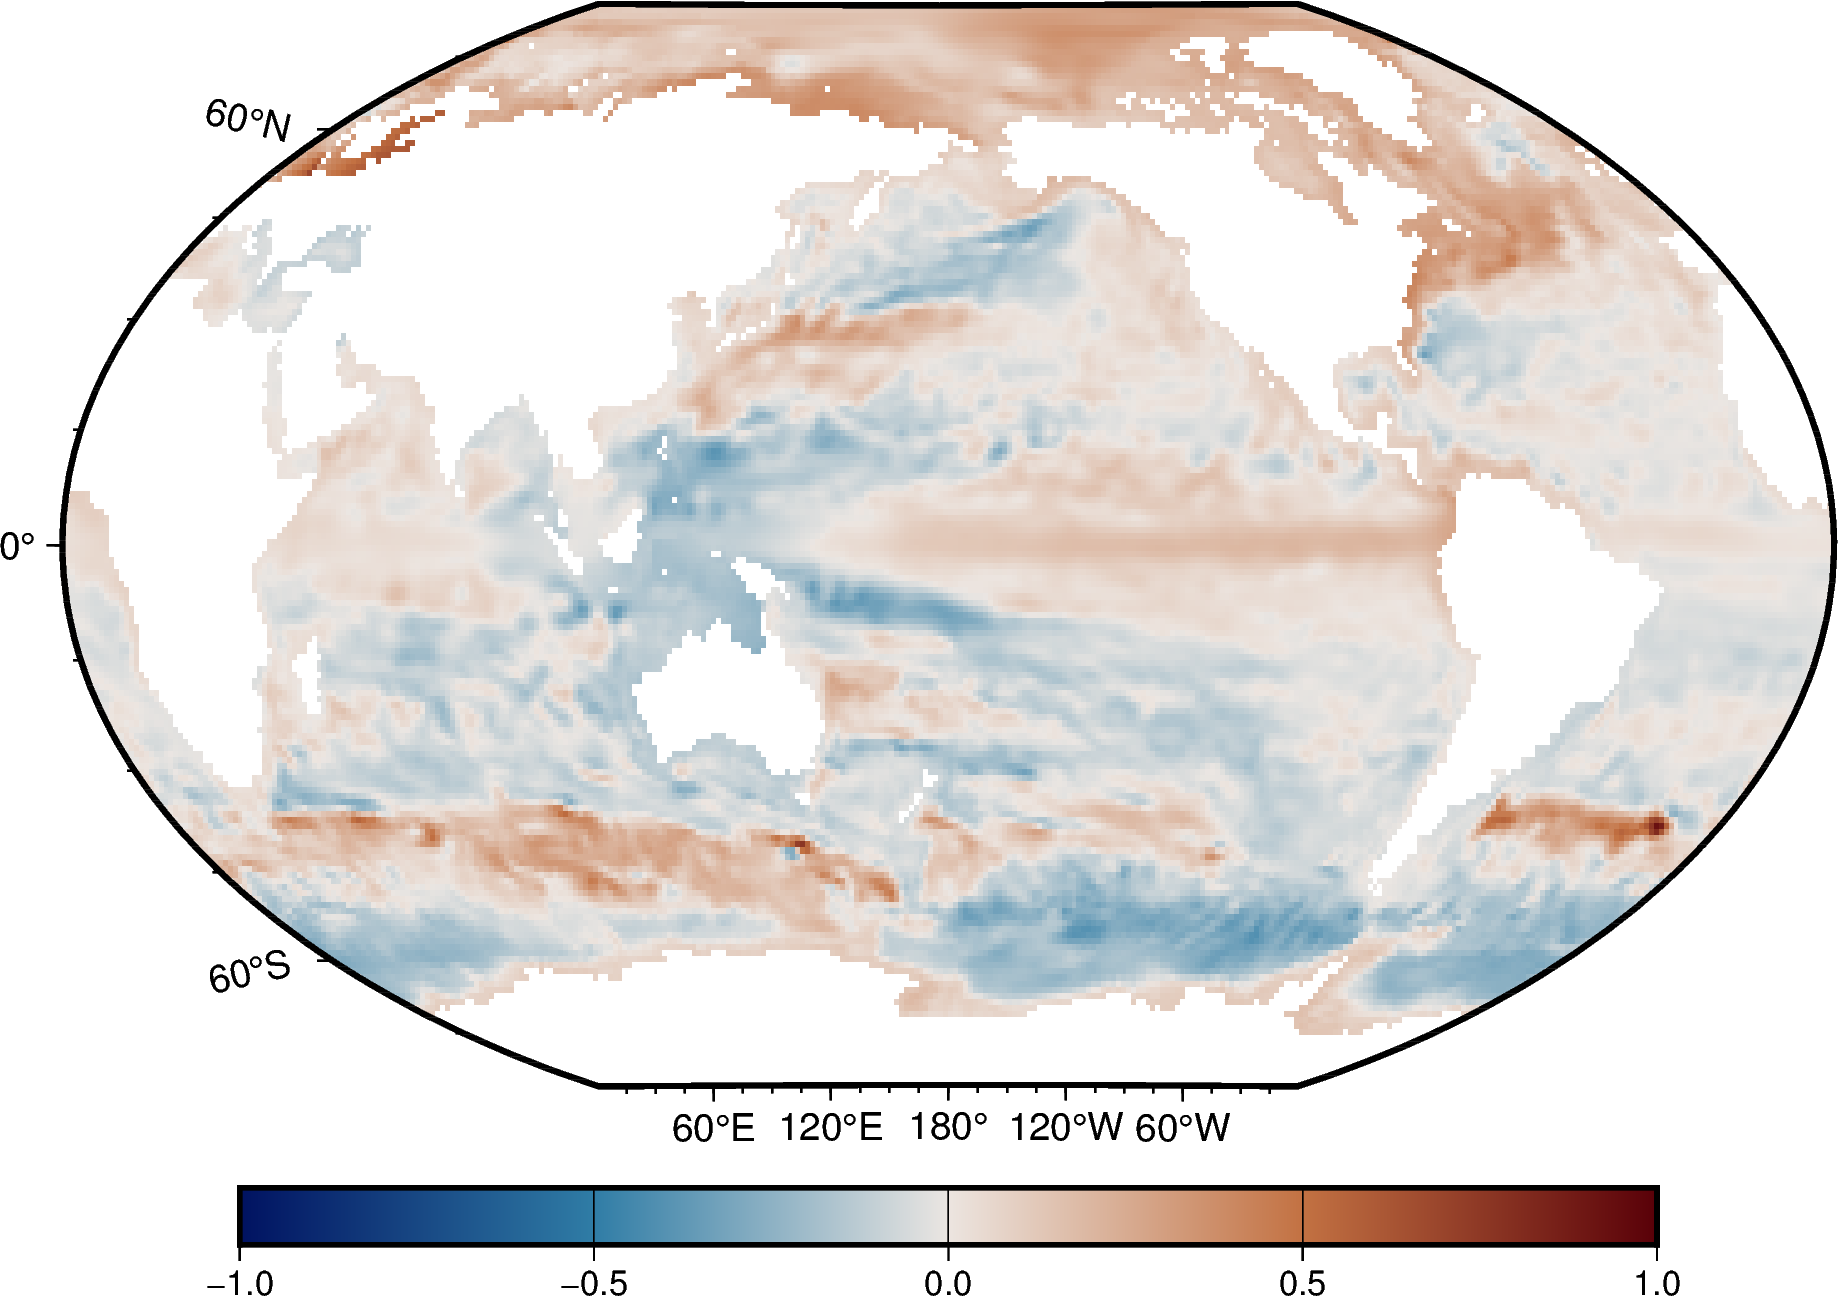

In [10]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="vik", series=[-1, 1, 0.5], continuous=True)
fig.grdimage(grid=sealevelchange, cmap=True, projection="R15c", frame=True)
fig.colorbar()
fig.show()